##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Hub

[TensorFlow Hub](http://tensorflow.org/hub) is an online repository of already trained TensorFlow models that you can use.
These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

Here, you can see all the models available in [TensorFlow Module Hub](https://tfhub.dev/).

Before starting this Colab, you should reset the Colab environment by selecting `Runtime -> Reset all runtimes...` from menu above.

# Imports


Some normal imports we've seen before. The new one is importing tensorflow_hub which this Colab will make heavy use of.

In [2]:
import tensorflow as tf

2023-02-26 11:41:52.549186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#  Download the Flowers Dataset using TensorFlow Datasets

In the cell below you will download the Flowers dataset using TensorFlow Datasets. If you look at the [TensorFlow Datasets documentation](https://www.tensorflow.org/datasets/datasets#tf_flowers) you will see that the name of the Flowers dataset is `tf_flowers`. You can also see that this dataset is only split into a TRAINING set. You will therefore have to use `tfds.splits` to split this training set into to a `training_set` and a `validation_set`. Do a `[70, 30]` split such that 70 corresponds to the `training_set` and 30 to the `validation_set`. Then load the `tf_flowers` dataset using `tfds.load`. Make sure the `tfds.load` function uses the all the parameters you need, and also make sure it returns the dataset info, so we can retrieve information about the datasets.


In [5]:
(training_set, validation_set, test_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

2023-02-26 11:41:59.040430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#  Print Information about the Flowers Dataset

Now that you have downloaded the dataset, use the dataset info to print the number of classes in the dataset, and also write some code that counts how many images we have in the training and validation sets. 

In [6]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2202
Total Number of Validation Images: 734 



The images in the Flowers dataset are not all the same size.

In [7]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [8]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 100

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [9]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

### Freeze the Pre-Trained Model

In the cell below freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [10]:
feature_extractor.trainable = False

### Train the mechanized model

In the cell bellow train this model like any other, by first calling `compile` and then followed by `fit`. Make sure you use the proper parameters when applying both methods. Train the model for only 6 epochs.

In [11]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism
model = MechanizedSequential([
    feature_extractor,
    layers.Dense(num_classes)
])



In [12]:
model.choose_mech(None)

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 2

empirical_history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/2
23/23 [==============================] - 44s 2s/step - loss: 1.1459 - accuracy: 0.5718 - val_loss: 0.7274 - val_accuracy: 0.7398
Epoch 2/2
23/23 [==============================] - 47s 2s/step - loss: 0.5923 - accuracy: 0.8015 - val_loss: 0.5449 - val_accuracy: 0.8093


In [14]:
num_test_examples = len(test_set)
test_batches = test_set.map(format_image).batch(BATCH_SIZE)
test_images, test_labels = tuple(zip(*test_set))

predicted = model.predict(test_batches)
predicted_ids = np.argmax(tf.squeeze(predicted).numpy(), axis=-1)

### Compute the accuracy rate
acc = (test_labels == predicted_ids).sum() * 1.0 / num_test_examples
print("Predicting Accuracy is: {} ".format(acc))
model.choose_mech(None)
test_loss, test_accuracy = model.evaluate(test_batches, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

8/8 [==============================] - 10s 1s/step
Predicting Accuracy is: 0.8051771117166212 
8/8 [==============================] - 9s 1s/step - loss: 0.5282 - accuracy: 0.8052
Accuracy on test dataset: 0.8051770925521851


In [22]:
model.choose_mech(Mechanism.GAUSSIAN)
model.set_mechanism_para(sigma = 0.1)


model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],
  run_eagerly = True)

EPOCHS = 2

gaussian_history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 1/23 [>.............................] - ETA: 11:41 - loss: 2.3277 - accuracy: 0.1500In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 2/23 [=>............................] - ETA: 8:18 - loss: 2.1208 - accuracy: 0.2200 In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 3/23 [==>...........................] - ETA: 8:28 - loss: 2.0238 - accuracy: 0.2400In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 4/23 [====>.........................] - ETA: 7:51 - loss: 1.9305 - accuracy: 0.2450In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 5/23 [=====>........................] - ETA: 7:26 - loss: 1.8457 - accuracy: 0.2660In Gaussian Mechanism
Create Gaussian noise when accessing the training data
 6/23 [======>.......................] - ETA: 6:55 - loss: 1.7894 - accuracy: 0.2833In Gaussian Mechanism


### Compute the generalization error

In [23]:
predicted = model.predict(test_batches)
predicted_ids = np.argmax(tf.squeeze(predicted).numpy(), axis=-1)

acc = (test_labels == predicted_ids).sum() * 1.0 / num_test_examples
print("Predicting Accuracy is: {} ".format(acc))
model.choose_mech(None)
test_loss, test_accuracy = model.evaluate(test_batches, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

8/8 [==============================] - 9s 1s/step
Predicting Accuracy is: 0.6975476839237057 
8/8 [==============================] - 9s 1s/step - loss: 0.8043 - accuracy: 0.6975
Accuracy on test dataset: 0.6975476741790771


In [17]:
model.choose_mech(Mechanism.THRESHOLD)
model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],
  run_eagerly = True)

EPOCHS = 2

threshold_history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/2
In Threshold out Mechanism
0.9088396
 1/23 [>.............................] - ETA: 3:51 - loss: 0.3540 - accuracy: 0.8833In Threshold out Mechanism
0.15572016
 2/23 [=>............................] - ETA: 2:41 - loss: 0.4572 - accuracy: 0.8167In Threshold out Mechanism
0.31578678
 3/23 [==>...........................] - ETA: 2:09 - loss: 0.4341 - accuracy: 0.7937In Threshold out Mechanism
0.33518893
 4/23 [====>.........................] - ETA: 2:51 - loss: 0.4417 - accuracy: 0.8227In Threshold out Mechanism
0.47487998
 5/23 [=====>........................] - ETA: 3:00 - loss: 0.4396 - accuracy: 0.8321In Threshold out Mechanism
0.437572
 6/23 [======>.......................] - ETA: 2:34 - loss: 0.4281 - accuracy: 0.8375In Threshold out Mechanism
0.23160048
 7/23 [========>.....................] - ETA: 2:20 - loss: 0.4150 - accuracy: 0.8474In Threshold out Mechanism
0.16996594
 8/23 [=========>....................] - ETA: 2:07 - loss: 0.4046 - accuracy: 0.8568In Threshold out 

/Users/admin/iCloud Drive (Archive)/Documents/.git/AdaptiveAnalysis-jiawen/AdaptivityAnalysis/eval/benchmark/tensorflow/mechanized-model/../mechanism/mechanized_sequential.py:222: RuntimeWarning: invalid value encountered in true_divide
  diff = (np.sum(y_pred_train, axis = 0) / train_size - np.sum(y_pred_hold, axis = 0) / hold_size)


23/23 [==============================] - 174s 7s/step - loss: 0.4195 - accuracy: 0.8453 - val_loss: 0.4258 - val_accuracy: 0.8379
Epoch 2/2
In Threshold out Mechanism
0.7706624
 1/23 [>.............................] - ETA: 2:42 - loss: 0.4332 - accuracy: 0.8500In Threshold out Mechanism
0.24553004
 2/23 [=>............................] - ETA: 1:45 - loss: 0.3880 - accuracy: 0.9100In Threshold out Mechanism
0.6568263
 3/23 [==>...........................] - ETA: 1:59 - loss: 0.3609 - accuracy: 0.9187In Threshold out Mechanism
0.23325948
 4/23 [====>.........................] - ETA: 2:00 - loss: 0.3375 - accuracy: 0.9091In Threshold out Mechanism
0.43729028
 5/23 [=====>........................] - ETA: 1:48 - loss: 0.3484 - accuracy: 0.9000In Threshold out Mechanism
0.7349975
 6/23 [======>.......................] - ETA: 1:39 - loss: 0.3340 - accuracy: 0.9067In Threshold out Mechanism
0.72640055
 7/23 [========>.....................] - ETA: 1:36 - loss: 0.3429 - accuracy: 0.9000In Thresh

### Compute the generalization error

In [18]:
predicted = model.predict(test_batches)
predicted_ids = np.argmax(tf.squeeze(predicted).numpy(), axis=-1)

acc = (test_labels == predicted_ids).sum() * 1.0 / num_test_examples
print("Predicting Accuracy is: {} ".format(acc))
model.choose_mech(None)
test_loss, test_accuracy = model.evaluate(test_batches, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

8/8 [==============================] - 11s 1s/step
Predicting Accuracy is: 0.8814713896457765 
8/8 [==============================] - 12s 2s/step - loss: 0.3489 - accuracy: 0.8815
Accuracy on test dataset: 0.8814713954925537


#  Plot Training and Validation Graphs

In the cell below, plot the training and validation accuracy/loss graphs.

In [28]:
def plot_loss_acc(history, mech="baseline"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label= ('Training Accuracy-'+ mech))
    plt.plot(epochs_range, val_acc, label=('Validation Accuracy-'+ mech))
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss-'+ mech)
    plt.plot(epochs_range, val_loss, label='Validation Loss-'+ mech)
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')


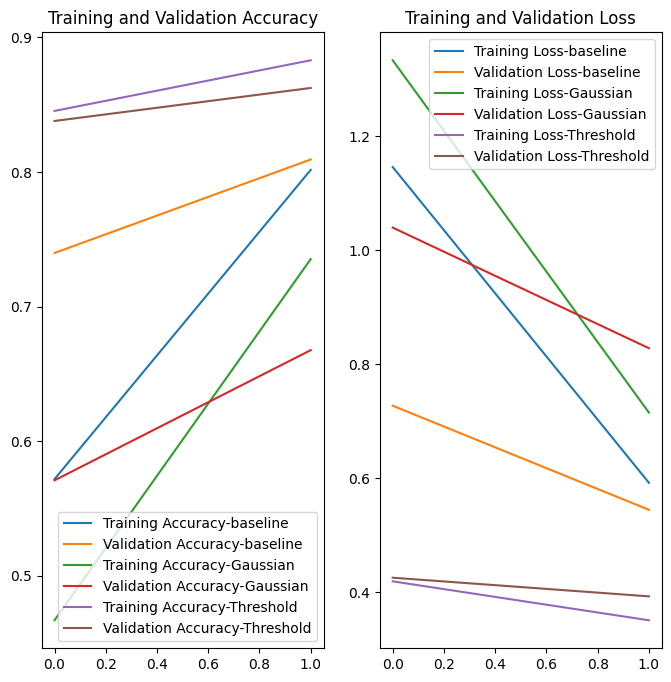

In [30]:
plt.figure(figsize=(8, 8))
plot_loss_acc(empirical_history)
plot_loss_acc(gaussian_history, "Gaussian")
plot_loss_acc(threshold_history, "Threshold")
plt.show()


What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Flower images. 

#  Perform Transfer Learning with the Inception Model

Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) and click on `tf2-preview/inception_v3/feature_vector`. This feature vector corresponds to the Inception v3 model. In the cells below, use transfer learning to create a CNN that uses Inception v3 as the pretrained model to classify the images from the Flowers dataset. Note that Inception, takes as input, images that are 299 x 299 pixels. Compare the accuracy you get with Inception v3 to the accuracy you got with MobileNet v2.

In [40]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)


train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)


In [41]:

model_inception = MechanizedSequential([
   feature_extractor,
  tf.keras.layers.Dense(num_classes)
])
EPOCHS = 2


model_inception.choose_mech(None)

model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


empirical_history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)


Epoch 1/2
26/26 [==============================] - 236s 9s/step - loss: 0.9324 - accuracy: 0.6684 - val_loss: 0.5897 - val_accuracy: 0.8138
Epoch 2/2
26/26 [==============================] - 224s 9s/step - loss: 0.4996 - accuracy: 0.8350 - val_loss: 0.4403 - val_accuracy: 0.8629


In [45]:

class MechanizedSequential(tf.keras.Sequential):


  def __init__(self, *args, **kwargs):
      super(MechanizedSequential, self).__init__(*args, **kwargs)
      self.mechanism = None


      '''
      Parameters for the GnC mechanism 
      '''
      self.mu = 0.0
      self.sigma = 0.03

      '''
      Parameters for the GnC mechanism 
      '''      
      self.beta = None
      self.tau = None
      self.check_for_width = None   


      '''
      Parameters for the Naive Data Splitting mechanism 
      '''
      self.split_size = None


      '''
      Parameters for the Thresholdout mechanism 
      '''
      self.hold_size = None
      self.train_size = None
      self.hold_frac = None
      self.threshold = None
      self.noisy_thresh = None
         
  def choose_mech(self, mech = None):
     self.mechanism = mech
  
  def set_gaussian_para(self, mu, sigma):
     self.set_mechanism_para(mu, sigma)

  def set_mechanism_para(self, mu = 0.0, sigma = None, hold_frac = 0.5, threshold = 0.5, beta = None, tau = None, check_for_width = None):
      self.mu = mu
      self.sigma = sigma
      self.beta = beta
      self.tau = tau
      self.check_for_width = check_for_width
      assert 0.0 < hold_frac <= 1.0, "hold_frac should take a value in (0, 1]."
      self.hold_frac = hold_frac
      self.threshold = threshold
      self.noisy_thresh = self.threshold + np.random.laplace(0, 2 * self.sigma)
     
  def compute_metrics_gaussin(self, x, y, y_pred, sample_weight):
      x_noise = tf.random.normal(
            tf.shape(x),
            mean=self.mu,
            stddev=self.sigma,
            dtype=x.dtype,
            seed=None,
            name=None
            )
      
      noised_x = x_noise + x
  
      y_noise = tf.random.normal(
        tf.shape(y),
        mean=self.mu,
        stddev=self.sigma,
        dtype = y.dtype,
        seed=None,
        name=None
        )
      noised_y = y + y_noise

      self.compiled_metrics.update_state(noised_y, y_pred, sample_weight)

      metrics_results = super(MechanizedSequential, self).compute_metrics(
        noised_x, y, y_pred, sample_weight)
      return metrics_results
  
  def compute_metrics(self, x, y, y_pred, sample_weight):
      if self.mechanism is None:
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        return super(MechanizedSequential, self).compute_metrics(
        x, y, y_pred, sample_weight)
      elif self.mechanism == Mechanism.GAUSSIAN:
         return super(MechanizedSequential, self).compute_metrics(
        x, y, y_pred, sample_weight)
         # return self.compute_metrics_gaussin(x, y, y_pred, sample_weight)
      else:
         self.compiled_metrics.update_state(y, y_pred, sample_weight)
         return super(MechanizedSequential, self).compute_metrics(
        x, y, y_pred, sample_weight)
      
  def train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      if self.mechanism is None:
        return super(MechanizedSequential, self).train_step(data)
      elif self.mechanism == Mechanism.GAUSSIAN:
         print("In Gaussian Mechanism")
         return self.gaussian_train_step(data)
      elif self.mechanism == Mechanism.DATASPLIT:
         print("In Naive Data Splitting Mechanism")
         return self.data_split_train_step(data)
      elif self.mechanism == Mechanism.THRESHOLD:
         print("In Threshold out Mechanism")
         return self.thresholdout_train_step(data)
      else:
        return super(MechanizedSequential, self).train_step(data)

      
  
  def gaussian_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      x, y = data
      with tf.GradientTape() as tape:
         print("Create Gaussian noise when accessing the training data")
         x_noise = tf.random.normal(
               tf.shape(x),
               mean=self.mu,
               stddev=self.sigma,
               dtype=x.dtype,
               seed=None,
               name=None
               )
         noised_x = x_noise + x
         y_pred = self(noised_x, training=True)  # Forward pass

         noise = tf.random.normal(
               tf.shape(y_pred),
               mean=self.mu,
               stddev=self.sigma,
               dtype = y_pred.dtype,
               seed=None,
               name=None
               )
         
         loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}
  
  '''
  Naive Data Splitting Mechanism:
  Either splitting the data in smaller batch-size and train with more steps,
  or doing the same training steps as the one without any mechanism.
  This one is the version that is the same as the train_step without any mechanism.
  '''
  def data_split_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.

      x, y = data
      with tf.GradientTape() as tape:
         print("In Naive Data Split")
         y_pred = self(x, training=True)  # Forward pass
         loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}
  
  def thresholdout_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      x, y = data
      if(x.shape[0] > 1):
         hold_size, train_size = int(x.shape[0]  * (self.hold_frac)), int(x.shape[0]  * (1.0 - self.hold_frac))
         x_train, y_train, x_hold, y_hold = x[hold_size:], y[hold_size:], x[:hold_size], y[:hold_size]
      else:
         hold_size, train_size = x.shape[0], x.shape[0]
         x_train, y_train, x_hold, y_hold = x, y, x, y
         
      with tf.GradientTape() as tape:

         y_pred_train = self(x_train, training=True)  # Forward pass
         y_pred_hold = self(x_hold, training = True)
         '''
         TODO: Need to consider one of the following model as one shot of query:
          model-1. one step of training, the result of the logistic is a query
          model-2. one step of training, the losse of the trained logistic v.s. the true logistic.
         '''

         '''
         model-1.
         drawback: the query result isn't unform data type, the trained logistic has different size dependents on the databse size.
         '''
         #TODO: subtraction between the tensors of different size
         diff = (np.sum(y_pred_train, axis = 0) / train_size - np.sum(y_pred_hold, axis = 0) / hold_size)
         mean_abs_diff = np.absolute(diff).mean()
         print(mean_abs_diff)
         if mean_abs_diff >= self.noisy_thresh + np.random.laplace(0, 4 * self.sigma):
            self.noisy_thresh = self.threshold + np.random.laplace(0, 2 * self.sigma)
            y_true, y_pred = y_hold, y_pred_hold + tfp.distributions.Laplace(self.mu, self.sigma).sample(tf.shape(y_pred_hold))
            loss = self.compiled_loss(y_hold, y_pred_hold, regularization_losses=self.losses)
         else:
            y_true, y_pred = y_train, y_pred_train
            loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)

         '''
         model-2:
         drawback: the "loss of  the trained logistic v.s. the true logistic" isn't a direct
          query on the data. 
         advantage: the losses in different steps or different size of database always have the same type.
         '''
         loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)
         loss_hold = self.compiled_loss(y_hold, y_pred_hold, regularization_losses=self.losses)

         if np.abs(loss - loss_hold) >= self.noisy_thresh + np.random.laplace(0, 4 * self.sigma):
            self.noisy_thresh = self.threshold + np.random.laplace(0, 2 * self.sigma)

            loss = loss_hold + tfp.distributions.Laplace(self.mu, self.sigma).sample(tf.shape(loss_hold))
            # min(1.0, max(0.0, loss_hold + np.random.laplace(0, self.sigma)))
            y_true, y_pred = y_hold, y_pred_hold
         else:
            y_true, y_pred = y_train, y_pred_train
            loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)

      
      
      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)
      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y_true, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}

In [46]:
IMAGE_RES = 224

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
# train_batches = training_set.cache().repeat().shuffle(num_training_examples).map(format_image).batch(BATCH_SIZE)
# validation_batches = validation_set.map(format_image).batch(BATCH_SIZE)

BATCH_SIZE = 100

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

# train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

In [47]:

model_inception = MechanizedSequential([
   feature_extractor,
  tf.keras.layers.Dense(num_classes)
])


model_inception.choose_mech(Mechanism.GAUSSIAN)
model_inception.set_mechanism_para(sigma = 0.1)

model_inception.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              run_eagerly = True)


gaussian_history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches
                    )

Epoch 1/2


TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:


model_inception.choose_mech(Mechanism.THRESHOLD)
model_inception.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)

model_inception.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              run_eagerly = True)


threshold_history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches
                    )

Epoch 1/2


ValueError: Input 0 of layer "mechanized_sequential_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(100, 299, 299, 3)

In [ ]:
plt.semilogx(empirical_history.history["lr"], empirical_history.history["loss"], label = "Baseline")
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.semilogx(threshold_history.history["lr"], threshold_history.history["loss"], label = "Thresholdout")
plt.legend()
plt.show()